In [ ]:
import cv2
import numpy as np
from openvino.runtime import Core
from yaspin import yaspin
from pathlib import Path
import fitz as pdf
import matplotlib.pyplot as plt
from lexpy.trie import Trie
from os import listdir
from scipy.spatial.distance import hamming

from openvino.runtime import Core


In [ ]:
ie = Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-0016"
base_model_dir = Path("~/open_model_zoo_models").expanduser()
omz_cache_dir = Path("~/open_model_zoo_cache").expanduser()

model_dir.mkdir(exist_ok=True)

In [ ]:
download_command = f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {omz_cache_dir} --precision {precision}"
with yaspin(text=f"Downloading {detection_model}, {recognition_model}") as sp:
    download_result = !$download_command
    sp.text = f"Finished downloading {detection_model}, {recognition_model}"
    sp.ok("✔")

In [ ]:
text_detection_path = Path(f"{model_dir}/intel/{detection_model}/{precision}/{detection_model}")
text_recognition_encoder_path = Path(f"{model_dir}/intel/{recognition_model}/{recognition_model}-encoder/{precision}/{recognition_model}-encoder")
text_recognition_decoder_path = Path(f"{model_dir}/intel/{recognition_model}/{recognition_model}-decoder/{precision}/{recognition_model}-decoder")
assert Path(text_detection_path.with_suffix('.xml')).is_file(), "Text detection model is not downloaded"
assert Path(text_recognition_encoder_path.with_suffix('.xml')).is_file(), "Text recognition encoder is not downloaded"
assert Path(text_recognition_decoder_path.with_suffix('.xml')).is_file(), "Text recognition decoder is not downlaoded"

In [ ]:
detection_model_file = ie.read_model(text_detection_path.with_suffix('.xml'))
recognition_encoder_model_file = ie.read_model(text_recognition_encoder_path.with_suffix('.xml'))
recognition_decoder_model_file = ie.read_model(text_recognition_decoder_path.with_suffix('.xml'))

In [ ]:
pdffile_name = "175975.pdf"
doc = pdf.open(pdffile_name)
pix = doc[11].get_pixmap(dpi=150)
output = "outfile.jpeg"
pix.save(output)
image_file = "outfile.jpeg"
image = cv2.imread(image_file)
ih, iw, c = image.shape

UUID_side = image[-int(ih/5):, int(iw/6):int(iw/6)+int(ih/5)]
PID_side = image[-int(ih/6):, -int(ih/6):]
plt.imshow(image)

In [ ]:
def adjust_image_to_detection(image, model):
    _, _, H, W = model.input(0).shape
    resized_image = cv2.resize(image, (W, H))
    return np.expand_dims(resized_image.transpose(2, 0, 1), 0)
    

UUID_side_resized = adjust_image_to_detection(UUID_side, detection_model_file)
PID_side_resized = adjust_image_to_detection(PID_side, detection_model_file)

assert UUID_side_resized.shape == PID_side_resized.shape == tuple(detection_model_file.input(0).shape), "Invalid input shape"

In [ ]:
detection_model_compiled = ie.compile_model(detection_model_file, device_name="CPU")
output_key = detection_model_compiled.output("boxes")

In [ ]:
UUID_boxes = detection_model_compiled([UUID_side_resized])[output_key]
PID_boxes = detection_model_compiled([PID_side_resized])[output_key]

In [ ]:
remove_empty = lambda box: box[~np.all(box == 0, axis = 1)]
UUID_boxes_detected = remove_empty(UUID_boxes)
PID_boxes_detected = remove_empty(PID_boxes)

assert UUID_boxes_detected.shape[0] >= 1, "No UUID detected"
assert PID_boxes_detected.shape[0] >= 1, "No PID detected"

In [ ]:
PID_image_transposed = np.transpose(PID_side_resized[0], (1, 2, 0))
x_min, y_min, x_max, y_max, prob = map(int, PID_boxes_detected[0])
PID_cropped = PID_image_transposed[y_min:y_max, x_min:x_max]
plt.imshow(PID_cropped)

In [ ]:
UUID_image_transposed = np.transpose(UUID_side_resized[0], (1, 2, 0))
x_min, y_min, x_max, y_max, prob = map(int, UUID_boxes_detected[0])
UUID_cropped = UUID_image_transposed[y_min:y_max, x_min:x_max]
plt.imshow(UUID_cropped)

In [ ]:
encoder_input_layer = recognition_encoder_model_file.input(0)
partial_shape_encoder_input_layer = encoder_input_layer.partial_shape
partial_shape_encoder_input_layer[3] = -1
recognition_encoder_model_file.reshape({encoder_input_layer: partial_shape_encoder_input_layer})

encoder_model_compiled = ie.compile_model(recognition_encoder_model_file, device_name="CPU")
decoder_model_compiled = ie.compile_model(recognition_decoder_model_file, device_name="CPU")

In [ ]:
def resize_image_to_encoder(image, model):
    N, C, H, W = model.input(0).partial_shape
    IH, IW, IC = image.shape
    scale_ratio = H.get_length() / IH
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized_image = cv2.resize(
        grayscale_image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA
    )
    return resized_image[None, None,]
    
input_image_for_encoder = resize_image_to_encoder(UUID_cropped, encoder_model_compiled)
output_key_encoder_features = encoder_model_compiled.output('features')
output_key_encoder_hidden = encoder_model_compiled.output('decoder_hidden')

encoder_output = encoder_model_compiled([input_image_for_encoder])

encoder_output_features = encoder_output[output_key_encoder_features]
encoder_output_hidden = encoder_output[output_key_encoder_hidden]

In [ ]:
decoder_input_previous = decoder_model_compiled.input('decoder_input')
decoder_input_features = decoder_model_compiled.input('features')
decoder_input_hidden = decoder_model_compiled.input('hidden')

In [ ]:
first_decoder_input_dict = {
    decoder_input_previous: [0],
    decoder_input_features: encoder_output_features,
    decoder_input_hidden: encoder_output_hidden,
}

first_decoder_output = decoder_model_compiled(first_decoder_input_dict)

In [ ]:
decoder_output_hidden_key = decoder_model_compiled.output('decoder_hidden')
decoder_output_value_key = decoder_model_compiled.output('decoder_output')

decoder_output_hidden = first_decoder_output[decoder_output_hidden_key]
decoder_output_value = first_decoder_output[decoder_output_value_key]

alphabet = "0123456789abcdefghijklmnopqrstuvwxyz"
alphabet = [symbol for symbol in alphabet]
alphabet = ["[START]", "[END]", " ", "[NOT SURE]"] + alphabet
letter_idx = np.argmax(decoder_output_value)
answer = ""
while letter_idx not in [1, 2] and len(answer) < 10:
    answer += alphabet[letter_idx]
    decoder_input_dict = {
        decoder_input_previous: [letter_idx],
        decoder_input_features: encoder_output_features,
        decoder_input_hidden: decoder_output_hidden,
    }
    decoder_output = decoder_model_compiled(decoder_input_dict)
    decoder_output_hidden = decoder_output[decoder_output_hidden_key]
    decoder_output_value = decoder_output[decoder_output_value_key]
    letter_idx = np.argmax(decoder_output_value)

print(answer)


In [150]:
model_paths = {
    "encoder": text_recognition_encoder_path,
    "decoder": text_recognition_decoder_path,
    "detection": text_detection_path
}

def map_UUID_to_trie(path):
    trie = Trie()
    files = [f[:-4] for f in listdir(path)]
    trie.add_all(files)
    return trie

def resize_image_to_encoder(image, model):
    N, C, H, W = model.input(0).partial_shape
    IH, IW, IC = image.shape
    scale_ratio = H.get_length() / IH
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    resized_image = cv2.resize(
        grayscale_image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA
    )
    return resized_image[None, None,]

def prepare_alphabet():
    alphabet = "0123456789abcdefghijklmnopqrstuvwxyz"
    alphabet = [symbol for symbol in alphabet]
    return ["[START]", "[END]", " ", "[NOT SURE]"] + alphabet

def run_recognition(boxes, image, encoder_model, decoder_model):
    alphabet = prepare_alphabet()
    preprocessed_image = np.transpose(image[0], (1, 2, 0))
    x_min, y_min, x_max, y_max, _ = map(int, boxes)
    image_cropped = preprocessed_image[y_min:y_max, x_min:x_max]
    image_resized = resize_image_to_encoder(image_cropped, encoder_model)
    features_encoder, hidden_encoder = run_encoder_model(image_resized, encoder_model)
    decoder_input_previous = decoder_model.input('decoder_input')
    decoder_input_features = decoder_model.input('features')
    decoder_input_hidden = decoder_model.input('hidden')
    decoder_input_dict = {
        decoder_input_previous: [0],
        decoder_input_features: features_encoder,
        decoder_input_hidden: hidden_encoder,
    }
    hidden_decoder, value_decoder = run_decoder_model(decoder_input_dict, decoder_model)
    answer = ""
    while value_decoder not in (1, 2) and len(answer) <= 13:
        answer += alphabet[value_decoder]
        decoder_input_dict[decoder_input_previous] = [value_decoder]
        decoder_input_dict[decoder_input_hidden] = hidden_decoder
        hidden_decoder, value_decoder = run_decoder_model(decoder_input_dict, decoder_model)
    return answer

def pipeline(image: np.array, model_paths: dict, UUID_proportion: float = 0.3, PID_proportion: float = 1/5):
    detection_model_compiled, encoder_model_compiled, decoder_model_compiled = initialize_models(model_paths)
    ih, iw, _ = image.shape
    UUID_side = image[-int(ih*UUID_proportion):, :int(ih*UUID_proportion)]
    PID_side = image[-int(ih*PID_proportion):, -int(ih*PID_proportion):]
    UUID_PID = []
    for name, partial_image in zip(("UUID", "PID"), (UUID_side, PID_side)):
        preprocessed_image = adjust_image_to_detection(partial_image, detection_model_compiled)
        boxes = detect_boxes(preprocessed_image, detection_model_compiled)
        assert boxes.shape[0] >= 1, f"Boxes shape: {boxes.shape}. Failed in {name} part"
        if boxes.shape[0] > 1:
            if name == "UUID":
                boxes = sorted(boxes, key=lambda value: value[3], reverse=True) 
            elif name == "PID":
                boxes = sorted(boxes, key=lambda value: value[3], reverse=True)
        for box in boxes:
            answer = run_recognition(box, preprocessed_image, encoder_model_compiled, decoder_model_compiled)
            if answer.isnumeric() and (name == "UUID" and len(answer) >= 7) or (name == "PID" and len(answer) < 2):
                break
        UUID_PID.append(answer)
    return UUID_PID

def check_if_correct(UUID, trie):
    if UUID in trie:
        return UUID
    else:
        possible_matches = trie.search_within_distance(UUID, dist=1)
        if len(possible_matches) == 0:
            possible_matches = trie.search_within_distance(UUID, dist=1)

def initialize_models(models_paths: dict):
    detection_model_file = ie.read_model(models_paths["detection"].with_suffix('.xml'))
    recognition_encoder_model_file = ie.read_model(models_paths["encoder"].with_suffix('.xml'))
    recognition_decoder_model_file = ie.read_model(models_paths["decoder"].with_suffix('.xml'))
    encoder_input_layer = recognition_encoder_model_file.input(0)
    partial_shape_encoder_input_layer = encoder_input_layer.partial_shape
    partial_shape_encoder_input_layer[3] = -1
    recognition_encoder_model_file.reshape({encoder_input_layer: partial_shape_encoder_input_layer})

    detection_model_compiled = ie.compile_model(detection_model_file, device_name="CPU")
    encoder_model_compiled = ie.compile_model(recognition_encoder_model_file, device_name="CPU")
    decoder_model_compiled = ie.compile_model(recognition_decoder_model_file, device_name="CPU")
    return detection_model_compiled, encoder_model_compiled, decoder_model_compiled

def detect_boxes(image, model) -> np.array:
    remove_empty = lambda box: box[~np.all(box == 0, axis = 1)]
    output_key = model.output("boxes")
    return remove_empty(model([image])[output_key])

def run_encoder_model(image, model):
    output_key_encoder_features = model.output('features')
    output_key_encoder_hidden = model.output('decoder_hidden')
    encoder_output = model([image])
    encoder_output_features = encoder_output[output_key_encoder_features]
    encoder_output_hidden = encoder_output[output_key_encoder_hidden]
    return encoder_output_features, encoder_output_hidden

def run_decoder_model(inputs, model):
    decoder_model_output = model(inputs)
    decoder_output_hidden_key = model.output('decoder_hidden')
    decoder_output_value_key = model.output('decoder_output')
    decoder_output_hidden = decoder_model_output[decoder_output_hidden_key]
    decoder_output_value = decoder_model_output[decoder_output_value_key]
    return decoder_output_hidden, np.argmax(decoder_output_value)


In [152]:
trie = map_UUID_to_trie('/home/jakubdeb/repo/splinter/research/answers/answers')

pdffile_name = "scans/SKM_C364e22052617450.pdf"
doc = pdf.open(pdffile_name)
scan_set = []
for page in range(doc.page_count):
    pix = doc[page].get_pixmap(dpi=150)
    output = "outfile.jpeg"
    pix.save(output)
    image_file = "outfile.jpeg"
    image = cv2.imread(image_file)

    if np.mean(image) > 254.8:
        scan_set.append([None, None])
    else:
        try:
            scan_set.append(pipeline(image, model_paths))
        except AssertionError as e:
            scan_set.append([None, None])
            print(f"Failure at {page}, details: {e}")


for idx, (uuid, pid) in enumerate(scan_set):
    if uuid is None and pid is None:
        continue
    elif uuid not in trie:
        if idx > 0:
            previous_exam = scan_set[idx-1] if (scan_set[idx-1][0] is not None) or idx == 1 else scan_set[idx-2] 
            if hamming(uuid, previous_exam[0]) <= 1/4 and previous_exam[0] in trie:
                scan_set[idx][0] = previous_exam[0]
        if idx < len(scan_set) - 1 and scan_set[idx][0] not in trie:    
            next_exam = scan_set[idx+1] if (scan_set[idx+1][0] is not None) or idx == len(scan_set) - 1 else scan_set[idx+2] 
            if hamming(uuid, next_exam[0]) <= 1/4 and next_exam[0] in trie:
                scan_set[idx][0] = next_exam[0]
        if scan_set[idx][0] not in trie:
            possible_matches = trie.search_within_distance(scan_set[idx][0], dist=1)
            if len(possible_matches) == 1:
                scan_set[idx][0] = possible_matches[0]
            else:
                print(f'DETECTED UUID: {uuid} POSSIBLE MATCHES: {possible_matches}, ABSOLUTE PAGE NO: {idx}') 

pages_to_exams = {}
for idx, (uuid, pid) in enumerate(scan_set):
    if uuid is None and pid is None:
        continue
    elif uuid in pages_to_exams.keys():
        pages_to_exams[uuid].append([idx, pid])
    else:
        pages_to_exams[uuid] = [[idx, pid]]

for key, value in pages_to_exams.items():
    pages_to_exams[key] = [v[0] for v in sorted(value, key=lambda x: x[1])]

for key, value in pages_to_exams.items():
    output_doc = pdf.open()
    for page in value:
        output_doc.insert_pdf(doc, from_page=page, to_page=page)
    output_doc.save(f'dataset/{key}.pdf')

print(pages_to_exams)

Failure at 8, details: Boxes shape: (0, 5). Failed in PID part
Failure at 21, details: Boxes shape: (0, 5). Failed in PID part
Failure at 23, details: Boxes shape: (0, 5). Failed in PID part
Failure at 27, details: Boxes shape: (0, 5). Failed in PID part
Failure at 30, details: Boxes shape: (0, 5). Failed in PID part
{'12842262': [0, 2, 3, 1, 4], '13399024': [6, 7, 5, 10, 9], '16660625': [13, 15, 14, 12, 11], '30867773': [16, 19, 18], '34770711': [17, 20, 22], '35880174': [24, 26, 25], '41451620': [28, 31, 29, 34, 32], '46392465': [33, 35, 38, 36], '52927905': [37, 39, 40, 42], '72344783': [43, 41, 46, 44]}


248.55277161930803

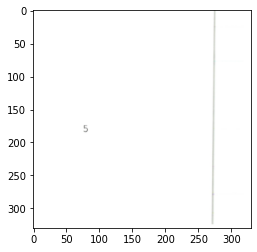

In [144]:

pix = doc[8].get_pixmap(dpi=150)
output = "outfile.jpeg"
pix.save(output)
output = 'outfile.jpeg' 
image = cv2.imread(output)
UUID_side = image[-int(ih/3):, :int(ih/3)]
PID_side = image[-int(ih/5):, -int(ih/5):]
plt.imshow(PID_side)
np.mean(image)